---
## Table of Contents
* [Objectives](#obj)
* [Introduction](#intro)
* [Problem Statement](#ps)
* [Input Data](#data)
* [Steady state](#ss)
* [Vector ODE System](#vodes)
* [Function library](#flib)
* [One-Group Energy Neutron Balance](#nbal)
* [Reactivity Step with Negative Feedback Results](#res1)
* [Interactive Results](#ires)
---

## Problem Statement<a id="ps"></a>

Consider a high temperature gas cooled reactor, with UO$_2$ fuel and a graphite moderator.
Given the neutron generation time $\ell$, delayed neutron fraction, $\beta$, decay constants of a six-group delayed neutron emitters, $\lambda_i$, and corresponding yield of delayed neutron fractions for each emitter, $\beta_i$, calculate the pointwise neutron density variation with time for **varying** neutron reactivity, $\rho(t)$.

![](images/point-reactor-hx.png)

## Input Data<a id="data"></a>




For thermal fission of $^{235}$U the following six-group delayed neutron precursors data is typically used (*Physics of Nuclear Kinetics*, G. R. Keepin, 1965, Addison-Wesley Pub. Co.):


Delayed neutron emitter group No. | Decay cte ($\lambda_i$,1/sec) | Relative yield ($\beta_i/\beta$) |
----------------------------------|-------------------------------|----------------------------------| 
1                                 | 0.0124                        | 0.033                            |
2                                 | 0.0305                        | 0.219                            | 
3                                 | 0.111                         | 0.196                            |  
4                                 | 0.301                         | 0.395                            | 
5                                 | 1.14                          | 0.115                            |
6                                 | 3.01                          | 0.042                            |

In [102]:
'''Parameters'''
import math
params = dict()
params['core_volume'] = 4.3 # m^3
#Data pertaining to one-group energy neutron balance
params['gen_time'] = 1.0e-4  # s
params['beta'] = 6.5e-3  #
params['diff_coeff']   = 0.84 # cm
params['k_infty'] = 1.5207
params['buckling'] = 1.538e-4
params['Sigma_a']      = 2.74e-4 # 1/cm
params['q_0'] = 0

#params['alpha_tn_fake'] = 0 # -1.0e-6

params['n_dens_ss_operation'] = 1.963e13/2200 * 1e4 #  #neutrons/m^2
params['alpha_n'] = -1.5e-3  # control rod reactivity worth

#Delayed neutron emission
params['species_decay'] = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01]  # 1/sec
params['species_rel_yield'] = [0.033, 0.219, 0.196, 0.395, 0.115, 0.042]

#Data pertaining to two-temperature heat balances
params['fis_energy'] = 180 * 1.602e-13  # J/fission
params['enrich'] = 5.0 / 100.
params['fuel_mat_mass_dens'] = 10.5  # g/cc
params['sigma_f_o'] = 586.2 * 100 * 1e-30  # m2
params['temp_o'] = 20 + 273.15  # K
params['temp_c_ss_operation'] = 265 + 273.15  # ss operation temp of coolant
params['thermal_neutron_velo'] = 2200  # m/s

params['fis_nuclide_num_dens_fake'] = 9.84e26  # (fissile nuclei)/m3

##########################################################################
params['coolant_dens'] = 742.02  #  kg/m3

params['m_c'] = 666 # coolant mass flow rate
c_rho = params['coolant_dens']
c_mflow = params['m_c'] 
params['q_c'] = c_mflow/c_rho # volumetric flow rate
params['fuel_dens'] = 10500  # kg/m3
params['cp_fuel'] = 300  # J/(kg K)
params['fuel_volume'] = 0.856  # m3
params['cp_coolant'] = 4000  # J/(mol K) - > J/(kg K)
params['coolant_volume'] = 62.9363  # m3
params['ht_coeff'] = 716845.88  # W/K assuming fuel temp of 600 C

params['m2'] = 28.44

params['hx_dt'] = 18 #   heat exchanger primary loop temp difference

params[
    'fis_prod_beta_energy_rate'] = 1.26 * 1.602e-13  # J/(fission sec) 1.26 t^-1.2 (t in seconds)
params[
    'fis_prod_alpha_energy_rate'] = 1.40 * 1.602e-13  # J/(fission sec) 1.40 t^-1.2 (t in seconds)



def testing():
    buckling = params['buckling']
    return buckling


a = 32
buckling = testing()


## One-Group Energy  Neutron Balance<a id="nbal"></a>

The space-invariant neutron balance for the point-reactor model is

\begin{equation*}
\frac{\text{d}n}{\text{d}t}  = \frac{\rho(t)-\beta}{\ell}\, n + \sum\limits_{i=1}^{6} \lambda_i\,c_i  + q(t),
\end{equation*}

where the first term on the right side of the equation represents the net production of neutrons not accounting for delayed neutrons, and the second term accounts for the source of delayed neutrons considering 6 groups of delayed neutron emitters resulting from the fission of $^{235}$U nuclei. Therefore a balance of neutron emitter species is also necessary

\begin{equation*}
\frac{\text{d}c_i}{\text{d}t}  = \frac{\beta_i}{\ell}\, n - \lambda_i\,c_i ,
     \ \ \ \ \ \forall \ \ \ \ \  i=1,\ldots,6.
\end{equation*}

where the first term on the right side of the equation is the source of emitters as a function of the neutron number density $n(t)$, and the second term is the consumption rate of the emitter by radioactive decay obtained as a function of the product of the number concentration of the emmiter, $c_i(t)$, multiplied by its decay constant $\lambda_i$. Here the number concentration of of the $i$th emitter, $c_i$ is considered in terms of delayed neutron number density, hence the units are the same as $n$.

The current model considers the temperature reactivity coefficient, $\alpha_{T_n}$, that is, 

\begin{equation*}
 \rho(t) = \rho_0 + \alpha_{T_n}(T_f)\,\bigl(T_f(t) - T^{(0)}\bigr),
\end{equation*}

where basic nuclear effects are taking into account through the sub-model

\begin{equation*}
 \alpha_{T_n}(T) = - \frac{B^2\,D}{2\,k_\infty\,\overline{\Sigma}_a^{(\text{o})}\,\sqrt{T^\text{(o)}\,T}}.
\end{equation*}

A heat balance in the static fuel dispersed into the moderator gives

\begin{equation*}
\frac{\text{d}T_f}{\text{d}t} = - \frac{1}{\rho_f\,c_{pf}}\biggl(q^{'''}(t) - \frac{\dot{Q}_\text{f}}{V_f} \biggr) 
\end{equation*}

where the heat rate sink in the fuel/moderator is 

\begin{equation*}
{\dot{Q}_\text{f}} = -UA\bigl(T_f-T_c\bigr), 
\end{equation*}

and the nuclear heating power is given by

\begin{equation*}
q^{'''}(t) = G_f\frac{\sqrt{\pi}}{2}\,\sigma_\text{fo}\,\sqrt{\frac{T^\text{(o)}}{T}}\,\biggl(\frac{\epsilon\,w_\text{fs}\,\rho_\text{fm}}{M_\text{fn}}\,i\,N_A\biggr)\,n(t)\,v_\text{(o)} .
\end{equation*}

A heat balance in the flowing coolant fluid produces

\begin{equation*}
\frac{\text{d}T_c}{\text{d}t} = -\frac{1}{\tau_c}\biggl(T_c-T_{in}\biggr)  
                                - \frac{1}{\rho_c\,c_{pc}}\biggl( \frac{\dot{Q}_\text{f}}{V_c} \biggr) 
\end{equation*}

where the heat rate source is the negative of the heat rate sink in the fuel/moderator.

## Steady State<a id="ss"></a>

Neutron density and delayed neutron precursor concentrations are related as follows:

\begin{align*}
n_\text{ss}  &= -\frac{q_\text{ss}\,\ell }{\rho_\text{ss} }
\\
c_{i_\text{ss}}  &= \frac{\beta_i}{\lambda_i\,\ell}\, n_\text{ss}   \ \ \ \ \forall \ \ \ \ i=1,\ldots,6 .
\end{align*}

In [59]:
'''Setup function for delayed neutron species concentrations at steady state'''

def setup_initial_conditions(params):
    
    # setup the steady state for the delayed-neutron precursors
    
    n_species = len(params['species_decay'])
    
    assert len(params['species_rel_yield']) == n_species
    
    import numpy as np
    c_vec_0 = np.zeros(n_species,dtype=np.float64) # initialize conentration vector

    species_decay = params['species_decay'] # retrieve list of decay constants
    lambda_vec    = np.array(species_decay) # create a numpy vector

    species_rel_yield = params['species_rel_yield']
    beta_vec = np.array(species_rel_yield) * beta  # create the beta_i's vector

    gen_time = params['gen_time'] # retrieve neutron generation time

    n_ss = params['n_ss']
    c_vec_ss = beta_vec/lambda_vec/gen_time * n_ss # compute the steady state precursors number density
    
    params['c_vec_ss'] = c_vec_ss
    
    # setup initial condition for variables
    params['n_0']     = n_ss
    params['c_vec_0'] = c_vec_ss
    params['rho_0']   = params['reactivity']
    
    params['temp_f_0'] = 300
    params['temp_c_0'] = params['temp_0']
    
    return


## Vector ODE System<a id="vodes"></a>

Refer to course notes OneNote [ChEn-3170-odes](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EmY427F-dSBKkpfFOx4ikf8BVAlJXL5iep1g7V7hcTQxJQ?e=98c69b).

A vector notation for the foregoing system of equations greatly improves the generality of the derived computer code. Towards this goal let us define

\begin{equation*}
\frac{d\uvar}{dt} = \fvar( \uvar, t )
\end{equation*}

where $\uvar(t) = (u_1,u_2,u_3,u_4,u_5,u_6,u_7)$ is the state vector and we assign 

\begin{align*}
 u_1(t)&=n(t),\\
 u_2(t)&=c_1(t),\\
 u_3(t)&=c_2(t),\\
 u_4(t)&=c_3(t),\\
 u_5(t)&=c_4(t),\\
 u_6(t)&=c_5(t),\\
 u_7(t)&=c_6(t),\\
 u_8(t)&=T_f(t),\\
 u_9(t)&=T_c(t).
\end{align*}

Also for $\fvar(\uvar,t) = \bigl(f_1(\uvar,t), f_2(\uvar,t), f_3(\uvar,t), f_4(\uvar,t), f_5(\uvar,t), f_6(\uvar,t), f_7(\uvar,t)\bigr)$ we assign 

\begin{align*}
 f_1 & = \frac{\rho(t)-\beta}{\ell}\, u_1 + \sum\limits_{i=2}^{7} \lambda_i\,u_i + q(t), \\
 f_2 & = \frac{\beta_1}{\ell}\, u_1 - \lambda_1\,u_2, \\
 f_3 & = \frac{\beta_2}{\ell}\, u_1 - \lambda_2\,u_3, \\
 f_4 & = \frac{\beta_3}{\ell}\, u_1 - \lambda_3\,u_4, \\
 f_5 & = \frac{\beta_4}{\ell}\, u_1 - \lambda_4\,u_5, \\
 f_6 & = \frac{\beta_5}{\ell}\, u_1 - \lambda_5\,u_6, \\
 f_7 & = \frac{\beta_6}{\ell}\, u_1 - \lambda_6\,u_7,  \\
 f_8 & = - \frac{1}{\rho_f\,c_{pf}}\biggl(q^{'''}(t) - \frac{\dot{Q}_\text{f}}{V_f} \biggr), \\
 f_9 & = -\frac{1}{\tau_c}\biggl(T_c-T_{in}\biggr)  
                                - \frac{1}{\rho_c\,c_{pc}}\biggl( \frac{\dot{Q}_\text{f}}{V_c} \biggr).
\end{align*}

Finally, the initial conditions given are as follows:

\begin{align*}
 u_1(0)&=n_0,\\
 u_2(0)&=c_{1_0},\\
 u_3(0)&=c_{2_0},\\
 u_4(0)&=c_{3_0},\\
 u_5(0)&=c_{4_0},\\
 u_6(0)&=c_{5_0},\\
 u_7(0)&=c_{6_0},\\
 u_8(0)&=T_{f_0},\\
 u_9(0)&=T_{c_0}
\end{align*}


where $n_0$ and $c_{i_0}$ are initial values for the unknowns given by the problem specification.

## Function Library <a id="flib"></a>

Functions used later in the notebook.

Reactivity coefficient based on nuclear effects through the sub-model. As this reactor uses a two-group neutron transport model (since water is both the moderator and the coolant), the derived equation is slightly different. M is the neutron transport area, which replaces L.

\begin{equation*}
\alpha_{T_n}(T) = - 2 \frac{B^2\,M^2}{k_\infty}\, 0.320886 \, (1 / T)^{0.75}
\end{equation*}

In [60]:
'''Reactivity coefficient function'''

def alpha_tn_func(temp):
    '''
    Place holder for implementation
    '''
    
    buckling = params['buckling']
    m2 = params['m2']
    k_infty = params['k_infty']
    T = temp
    
    alpha_tn = -2 * (buckling **2)  * math.sqrt(m2) * (1 / k_infty) * 0.320886 * (1 / T)**0.75
    
    
    return alpha_tn




In [61]:
'''Reactivity function'''

def rho_func( t, n_dens, temp, params ):
    '''
    Reactivity function.  
    
    Parameters
    ----------
    t: float, required
        Time.
    temp_f: float, required
        Temperature at time t.
    params: dict, required
        Dictionary of quantities. It must have a `'rho_0'` key/value pair.
    
    Returns
    -------
    rho_t: float
        Value of reactivity.

    Examples
    --------
    '''
    
    rho_0  = params['rho_0']
    temp_ref = params['temp_c_ss_operation']
    n_dens_ss_operation = params['n_dens_ss_operation']
    alpha_n = params['alpha_n']
    
    alpha_tn = alpha_tn_func(temp)
    
    rho_t = rho_0 + alpha_n * (n_dens) + alpha_tn * (temp - temp_ref)
    
    #print(rho_t)
    #print(n_dens)
        
    return rho_t

In [62]:
'''Source function'''

def q_source( t, params ):
    '''
    Neutron source delta function.  
    
    Parameters
    ----------
    t: float, required
        Time.
    params: dict, required
        Dictionary of quantities. It must have a `'q_0'` key/value pair.
    
    Returns
    -------
    q: float
        Value of source.

    Examples
    --------
    '''
    
    q = 0
    q_0 = params['q_0']
    
    if t <= 1e-5: # small time value
        q = q_0
    else:
        q = 0.0
        
    return q

#print("done")

The effective fission microscopic cross section for thermal neutrons will be taken as:

\begin{equation*}
\overline{\sigma}_\text{f}(T) = \frac{\sqrt{\pi}}{2}\,\sigma_\text{fo}\,\sqrt{\frac{T^\text{(o)}}{T}}
\end{equation*}

In [63]:
'''Effective microscopic fission cross section'''

def sigma_fis_func( temp, params ):
    '''
    Place holder for implementation
    '''
    
    sigma_f_fake = params['sigma_f_o'] * math.sqrt(298/temp) * math.sqrt(math.pi) * 0.5
    
    return sigma_f_fake




The nuclear heating power is given by

\begin{equation*}
q^{'''}(t) = G_f\,\overline{\sigma}_\text{f}(T)\,N_\text{fn} \,\varphi(t) .
\end{equation*}

In [64]:
'''Nuclear power density function'''

def nuclear_pwr_dens_func( time, temp, n_dens, params ):
    '''
    Place holder for implementation
    '''
    
    rxn_heat = params['fis_energy'] # get fission reaction energy J per reaction
    
    sigma_f = sigma_fis_func( temp, params ) # m2
    
    fis_nuclide_num_dens = params['fis_nuclide_num_dens_fake'] #  #/m3
    
    Sigma_fis = sigma_f * fis_nuclide_num_dens # macroscopic cross section
    
    v_o = params['thermal_neutron_velo'] # m/s
    
    neutron_flux = n_dens * 4.4E14 * v_o
    
     #reaction rate density
    rxn_rate_dens = Sigma_fis * neutron_flux
    
    # nuclear power source
    q3prime = - rxn_heat * rxn_rate_dens # exothermic reaction W/m3
    #q3prime = - n_dens * 3323E6
    #print("q3prime")
    #print(q3prime)
    
    return q3prime

The cooling heat rate is:

\begin{equation*}
{\dot{Q}_\text{f}} = -UA\bigl(T_f-T_c\bigr). 
\end{equation*}

In [65]:
'''Cooling heat rate'''

def heat_sink_rate( time, temp_f, temp_c, params):
    
    ht_coeff = params['ht_coeff']
    
    q_f = - ht_coeff * (temp_f - temp_c)
    print(q_f)
    
    return q_f

The coolant inlet temperature varies with the primary cooling loop heat exchanger which depends on the coolant temperature leaving the reactor. To mimic the heat exchanger let's do:

\begin{equation*}
T_\text{in}  = f(T_\text{c}) . 
\end{equation*}

In [88]:
'''Heat Exchanger'''

def coolant_inlet_temp_func( time, temp_c, params):
    
    dt = params['hx_dt'] # primary loop heat exchanger
    
    if temp_c < params['temp_c_ss_operation']:
        temp_in = temp_c -2
        
    else:
        #print('temp_c_ss_operation achieved')
        temp_in = params['temp_c_ss_operation']
    
    #print(temp_in)
    
    
    return temp_in

In [89]:
'''ODE function'''

def f_vec( time, u_vec, params ):  
    
    import numpy as np
    assert np.all(u_vec >= 0.0)
    
    n_dens = u_vec[0] # get neutron dens

    c_vec = u_vec[1:-2] # get delayed neutron emitter concentration
    
    temp_f = u_vec[-2] # get temperature of fuel
    
    temp_c = u_vec[-1] # get temperature of coolant
    
    # initialize f_vec to zero
    species_decay = params['species_decay']
    lambda_vec = np.array(species_decay)
    n_species  = len(lambda_vec)
    
    f_tmp = np.zeros(1+n_species+2,dtype=np.float64) # vector for f_vec return
    
    #----------------
    # neutron balance
    #----------------
    rho_t    = rho_func(time, n_dens, (temp_f+temp_c)/2.0, params)
    
    beta     = params['beta']
    gen_time = params['gen_time']
       
    species_rel_yield = params['species_rel_yield']
    beta_vec = np.array(species_rel_yield) * beta
    
    assert len(lambda_vec)==len(beta_vec)
    
    q_source_t = q_source(time, params)
    
    f_tmp[0] = (rho_t - beta)/gen_time * n_dens + lambda_vec @ c_vec + q_source_t
    
    #-----------------------------------
    # n species balances (implicit loop)
    #-----------------------------------
    f_tmp[1:-2] = beta_vec/gen_time * n_dens - lambda_vec * c_vec
    
    #--------------------
    # fuel energy balance
    #--------------------
    rho_f    = params['fuel_dens']
    cp_f     = params['cp_fuel']
    vol_fuel = params['fuel_volume']
    
    pwr_dens = nuclear_pwr_dens_func( time, (temp_f+temp_c)/2, n_dens, params )
    
    heat_sink = heat_sink_rate( time, temp_f, temp_c, params )
    #assert heat_sink <= 0.0,'heat_sink = %r'%heat_sink
    
    f_tmp[-2] =  -1/rho_f/cp_f * ( pwr_dens - heat_sink/vol_fuel )
    
    #-----------------------
    # coolant energy balance
    #-----------------------
    rho_c    = params['coolant_dens']
    cp_c     = params['cp_coolant']
    vol_cool = params['coolant_volume']
    
    temp_in = coolant_inlet_temp_func(time, temp_c, params)
    
    tau = params['tau_fake']
    
    heat_source = - heat_sink
    
    f_tmp[-1] = - 1/tau * (temp_c - temp_in) + 1./rho_c/cp_c/vol_cool * heat_source
    #print(time)
    #print(u_vec)
    return f_tmp

In [90]:
'''Create the point-reactor run function'''

def run_point_reactor( f_vec, params ):

    from scipy.integrate import odeint # Load ODE solver package

    import numpy as np
    time_final = params['time_final']
    n_time_stamps = params['n_time_stamps']
    time_stamps = np.linspace(0.0, time_final, num=n_time_stamps) # create the time stamps for solution values
    params['time_stamps'] = time_stamps
    
    max_n_steps_per_time_step = 1000 # max number of nonlinear algebraic solver iterations per time step

    n_0     = params['n_0']
    c_vec_0 = params['c_vec_0']
    
    temp_f_0 = params['temp_f_0']
    temp_c_0 = params['temp_c_0']
       
    # m-equation point reactor model
    n_species = len(c_vec_0)
    u_vec_0 = np.zeros(1+n_species+2,dtype=np.float64)
    
    u_vec_0[0]    = n_0
    u_vec_0[1:-2] = c_vec_0
    u_vec_0[-2]   = temp_f_0
    u_vec_0[-1]   = temp_c_0
            
    (u_vec_history, info_dict) = odeint( f_vec, u_vec_0, time_stamps,
                                         args=( params, ),
                                         rtol=1e-4, atol=1e-8, mxstep=max_n_steps_per_time_step,
                                         full_output=1, tfirst=True )
    #print(n_dens)
    #print(u_vec)
    #print(time_stamps)
    #print

    assert info_dict['message']=='Integration successful.',\
                     'Fatal: scipy.integrate.odeint failed %r'%info_dict['message']
    
    return u_vec_history

In [91]:
'''Plotting function definition'''

def plot_results( u_vec_history, normalize=True, semi_log=False, markers=False, precursors=True ):
    
    time_stamps = params['time_stamps']/3600
    tau = params['tau_fake']
        
    import matplotlib.pyplot as plt
    
    fig, ax1 = plt.subplots(1, figsize=(14, 6))

    if precursors == True:
        
        ax2 = ax1.twinx() # duplicate x axes to plot n and c_i's in different y axes
    
        color_ids = np.linspace(0,1,u_vec_history[:,1:-2].shape[1])
    
        for (j,color_id) in zip( range(u_vec_history[:,1:-2].shape[1]), color_ids ):
            color=plt.cm.nipy_spectral(color_id)
        
            if normalize == True:
                ax2.plot( time_stamps,u_vec_history[:,j+1]/params['c_vec_0'][j],'-.',color=color,label=r'$c_%i$'%(j+1) )
                ax2.set_ylabel(r'$c_i/c_{i_0}$',fontsize=16,color='black')
            else:
                ax2.plot( time_stamps,u_vec_history[:,j+1],'-.',color=color,label=r'$c_%i$'%(j+1) )
                ax2.set_ylabel(r'$c_i$',fontsize=16,color='black')
        
        ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
        ax2.legend(loc='lower right',fontsize=12)
        if semi_log == True:
            ax2.set_yscale('log') # uncomment to plot y in log scale
        #ax2.grid(True)

    if markers == True:
        if normalize == True:
            ax1.plot( time_stamps,u_vec_history[:,0]/params['n_0'],'-',marker='+',color='red',label=r'$n/n_0$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')
        else:
            ax1.plot( time_stamps,u_vec_history[:,0],'-',marker='+',color='red',label=r'$n$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')
    else:
        if normalize == True:
            ax1.plot(time_stamps,u_vec_history[:,0]/params['n_0'],'-',color='red',label=r'$n/n_0$' )
            ax1.set_ylabel(r'$n/n_0$',fontsize=16,color='black')
        else:
            ax1.plot(time_stamps,u_vec_history[:,0],'-',color='red',label=r'$n$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')

    ax1.set_xlabel(r'Time [h]',fontsize=16)
    
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='best',fontsize=12)
    if semi_log == True:
        ax1.set_yscale('log') # uncomment to plot y in log scale
    ax1.grid(True)

    plt.title(r'Point-Reactor Model: $\rho/\beta=$'
              +str(params['reactivity']/params['beta'])
              +r'; $q_0=$'+str(round(params['q_0'],2)),
              fontsize=18)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show() 

    print('')

In [92]:
'''Utility function to peak at results table'''

def peek(time,data, head=500, tail=100):  

    import pandas as pd
    
    pd.options.display.float_format = '{:.2e}'.format
    
    layout = {'time':time[:head]}
    
    layout['n'] = data[:head,0]
    
    for j in range(1,data[:,1:-2].shape[1]+1):
        layout['c_%i'%j] = data[:head,j]
        
    layout['temp_f'] = data[:head,-2]
    layout['temp_c'] = data[:head,-1]
        
    results = pd.DataFrame(layout)
    print(round(results,2))
    print('')
    
    #layout = {'time':time[-tail:]}
    
    #layout['n'] = data[-tail:,j]
    
    #for j in range(1,data[:,1:-2].shape[1]+1):
       # layout['c_%i'%j] = data[-tail:,j]
    
   # layout['temp_f'] = data[-tail:,-2]
   # layout['temp_c'] = data[-tail:,-1]
               
   # results = pd.DataFrame(layout)
   # print(round(results,2))
   # print('')

In [93]:
def quantities(u_vec_history, params, time_stamps):
    import pandas as pd
    data = dict()
    tmpl = list() #temp storage for q3 prime
    tompl = list() #manipulated q3 prime
    tampl = list() #heat removed
    
    for (time, n_dens, temp_f, temp_c) in zip(time_stamps, u_vec_history[:,0], u_vec_history[:,-2], u_vec_history[:,-1]):
        q3prime = nuclear_pwr_dens_func(time, temp_f, n_dens, params)
        tmpl.append(q3prime)
        heat_removed = -1 * heat_sink_rate("false", temp_f, temp_c, params)
        tampl.append(heat_removed)
    for i in tmpl:
        damp = -1 * i * params['fuel_volume']
        tompl.append(damp)
    #data['time [s]'] = time_stamps
    data["q''' [W/m3]"] =  tompl 
    data["heat removed [W/m3]"] = tampl
    quantities = pd.DataFrame( data )
    return(quantities)

## Reactor Startup: Reactivity Step with Pulsed Source<a id="res1"></a>

Neutronless reactor before time zero. At time zero, apply a pulsed source and a reactivity step.

In [94]:
'''Setup up initial conditions'''

import numpy as np

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 1

params['n_ss'] = 0 # neutronless steady state before start up

rho_0_over_beta = 0.25 # $

beta = params['beta'] # retrieve the delayed neutron fraction
params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 10 cents"

params['temp_0'] = params['temp_o']

params['tau_fake'] = 4.79 # s

# setup remaining initial conditions
setup_initial_conditions(params)

In [95]:
'''Evolve the point-reactor'''

time_final    = 3000# 450 # s
n_time_stamps = 4500 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = run_point_reactor( f_vec, params )
#print(u_vec_history)

-4910394.278000017
-4910393.253022915
-4910393.253348695
-4910392.228697333
-4910392.229023072
-4910132.275280279
-4910132.201110823
-4910126.489528782
-4910374.755591551
-4910374.755571585
-4910388.724806111
-4910388.7286183685
-4910385.228212402
-4910385.232024049
-4910378.246456666
-4910378.246455402
-4910378.238834676
-4910378.254078696
-4910384.903315019
-4910384.903348718
-4910384.574674038
-4910384.574707737
-4910383.91749305
-4910383.91749305
-4910383.917425694
-4910383.917560406
-4910384.47364678
-4910384.473649958
-4910384.37259222
-4910384.372595399
-4910384.170492636
-4910384.170492636
-4910383.968402627
-4910383.968402627
-4910383.96839623
-4910383.968408984
-4910384.130073379
-4910384.130073909
-4910384.089655141
-4910384.08965567
-4910384.008820172
-4910384.008820172
-4910383.927984674
-4910383.927983656
-4910383.847148647
-4910383.038793665
-4910383.038793747
-4910382.230438806
-4910382.230438888
-4910374.146894088
-4910374.146894088
-4910366.063356622
-4910366.06335662

In [96]:
peek(params['time_stamps'],u_vec_history)

        time        n      c_1      c_2      c_3      c_4      c_5      c_6  \
0   0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
1   6.70e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
2   1.33e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
3   2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
4   2.67e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
..       ...      ...      ...      ...      ...      ...      ...      ...   
495 3.30e+02 2.00e-02 7.30e-01 3.58e+00 1.48e+00 1.31e+00 1.10e-01 2.00e-02   
496 3.31e+02 2.00e-02 7.50e-01 3.67e+00 1.52e+00 1.34e+00 1.10e-01 2.00e-02   
497 3.31e+02 2.00e-02 7.70e-01 3.76e+00 1.55e+00 1.38e+00 1.20e-01 2.00e-02   
498 3.32e+02 2.00e-02 7.90e-01 3.86e+00 1.59e+00 1.41e+00 1.20e-01 2.00e-02   
499 3.33e+02 2.00e-02 8.10e-01 3.96e+00 1.63e+00 1.45e+00 1.20e-01 2.00e-02   

      temp_f   temp_c  
0   3.00e+02 2.93e+02  
1  

In [97]:
print(quantities(u_vec_history, params, params['time_stamps']))

-4910394.278000017
-4284799.751918167
-3762198.838950146
-3325517.0936071225
-2960046.3205015827
-2655114.8057547794
-2401177.649320814
-2188628.754981098
-2011404.0982940989
-1861855.5200781308
-1735883.2018858353
-1631216.5893856387
-1543945.0326484884
-1472506.7225671874
-1413414.1290592684
-1365333.629548511
-1325228.8258541941
-1291197.0161311703
-1263251.5781564387
-1238879.4913606877
-1218909.0140599052
-1201696.8124755733
-1187437.6492529921
-1175714.164187771
-1165602.116540475
-1156922.2796235748
-1149961.637472734
-1143961.0493380788
-1138624.134257727
-1134406.9856503347
-1130783.7851927762
-1127557.6660905436
-1124901.5785115995
-1122682.7835480054
-1120735.8220277603
-1119158.7828153882
-1118004.4480421331
-1117047.8340981465
-1116217.6130524497
-1115442.456974105
-1114651.0379321747
-1114198.0515652671
-1113839.8871990207
-1113514.6099680492
-1113185.961810151
-1112817.6846632073
-1112466.5928739342
-1112270.6003197604
-1112087.0411661516
-1111902.8729818424
-1111705.053

-705441135.4764085
-705441137.0680584
-705441138.6636878
-705441140.2632971
-705441141.8668858
-705441143.4744542
-705441145.086002
-705441146.7015296
-705441148.3210367
-705441149.9445237
-705441151.57199
-705441153.2034361
-705441154.8388618
-705441156.478267
-705441158.1216519
-705441159.7690164
-705441161.4203604
-705441163.0756843
-705441164.7349875
-705441166.3982705
-705441168.065533
-705441169.7367753
-705441171.4119971
-705441173.0911986
-705441174.7743795
-705441176.4615402
-705441178.1526804
-705441179.8478005
-705441181.5468999
-705441183.2499789
-705441184.9570377
-705441186.668076
-705441188.383094
-705441190.1020916
-705441191.8250688
-705441193.5520256
-705441195.2829621
-705441197.0178782
-705441198.7567737
-705441200.4996489
-705441202.2465038
-705441203.9973384
-705441205.7521524
-705441207.5109462
-705441209.2737195
-705441211.0404725
-705441212.8112051
-705441214.5859172
-705441216.3646091
-705441218.1472806
-705441219.9339316
-705441221.7245622
-705441223.5191724


-4910394.278000017
-4284799.751918167
-3762198.838950146
-3325517.0936071225
-2960046.3205015827
-2655114.8057547794
-2401177.649320814
-2188628.754981098
-2011404.0982940989
-1861855.5200781308
-1735883.2018858353
-1631216.5893856387
-1543945.0326484884
-1472506.7225671874
-1413414.1290592684
-1365333.629548511
-1325228.8258541941
-1291197.0161311703
-1263251.5781564387
-1238879.4913606877
-1218909.0140599052
-1201696.8124755733
-1187437.6492529921
-1175714.164187771
-1165602.116540475
-1156922.2796235748
-1149961.637472734
-1143961.0493380788
-1138624.134257727
-1134406.9856503347
-1130783.7851927762
-1127557.6660905436
-1124901.5785115995
-1122682.7835480054
-1120735.8220277603
-1119158.7828153882
-1118004.4480421331
-1117047.8340981465
-1116217.6130524497
-1115442.456974105
-1114651.0379321747
-1114198.0515652671
-1113839.8871990207
-1113514.6099680492
-1113185.961810151
-1112817.6846632073
-1112466.5928739342
-1112270.6003197604
-1112087.0411661516
-1111902.8729818424
-1111705.053

-705441124.4462886
-705441126.0100812
-705441127.5778534
-705441129.1496052
-705441130.7253366
-705441132.3050476
-705441133.8887384
-705441135.4764085
-705441137.0680584
-705441138.6636878
-705441140.2632971
-705441141.8668858
-705441143.4744542
-705441145.086002
-705441146.7015296
-705441148.3210367
-705441149.9445237
-705441151.57199
-705441153.2034361
-705441154.8388618
-705441156.478267
-705441158.1216519
-705441159.7690164
-705441161.4203604
-705441163.0756843
-705441164.7349875
-705441166.3982705
-705441168.065533
-705441169.7367753
-705441171.4119971
-705441173.0911986
-705441174.7743795
-705441176.4615402
-705441178.1526804
-705441179.8478005
-705441181.5468999
-705441183.2499789
-705441184.9570377
-705441186.668076
-705441188.383094
-705441190.1020916
-705441191.8250688
-705441193.5520256
-705441195.2829621
-705441197.0178782
-705441198.7567737
-705441200.4996489
-705441202.2465038
-705441203.9973384
-705441205.7521524
-705441207.5109462
-705441209.2737195
-705441211.0404725


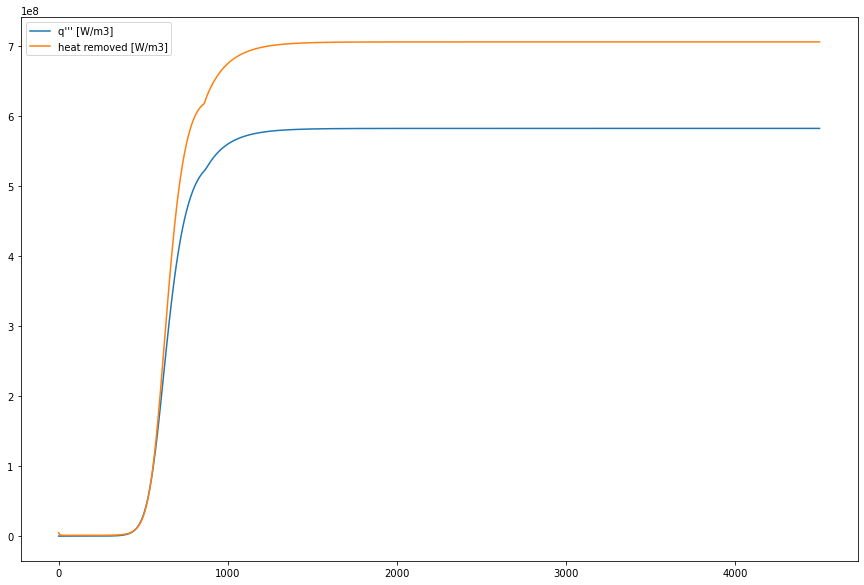

In [98]:
#plot the q3prime and heat removed data
heat_data = quantities(u_vec_history, params, params['time_stamps'])
heat_data.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=(15,10),
               use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, 
               xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, 
               yerr=None, xerr=None, secondary_y=False, sort_columns=False)


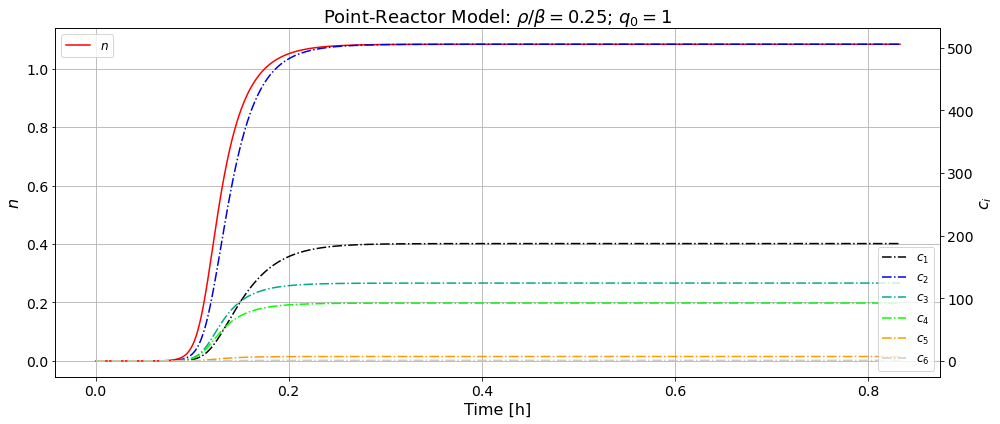

In [99]:
'''Plot neutron and delayed neutron emitter concentration in the reactor'''

plot_results(u_vec_history, normalize=False)

In [100]:
'''Plot Tf and Tc temperatures in the reactor'''

def tmp():
    time_stamps = params['time_stamps']
    tau = params['tau_fake']
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(1, figsize=(16, 6))
    ax1.plot(time_stamps/tau,u_vec_history[:,-2]-273.15,'b-',label='$T_f=$ ' )
    ax1.plot(time_stamps/tau,u_vec_history[:,-1]-273.15,'g-.',label='$T_c=$ ' )

    ax1.set_xlabel(r'Time [s]')
    ax1.set_ylabel(r'$T$ [C]',fontsize=16,color='blue')
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='best',fontsize=12)
    ax1.grid(True)

    #ax2 = ax1.twinx() 
    #ax2.plot(time_stamps/tau,u_vec_history[:,-1],'g-.',label='$T_c=$ ' )
   # ax2.set_ylabel(r'$T_c$ [K]',fontsize=16,color='green')
   # ax2.tick_params(axis='y', labelcolor='green', labelsize=14)
    #ax2.legend(loc='best',f/ontsize=12)
    #ax2.grid(True)

    plt.title('BWR simulation',fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

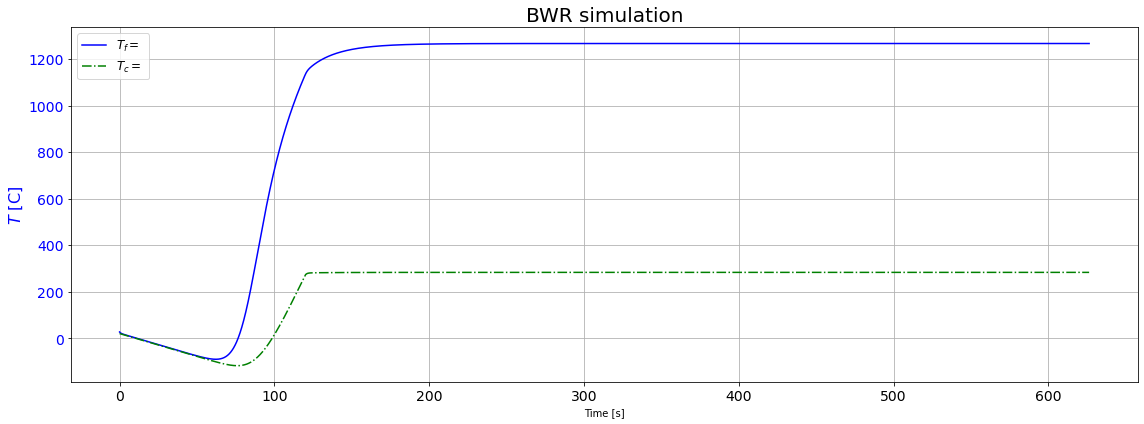

In [101]:
tmp()